In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from math import pow
import re
import math

from sklearn.impute import KNNImputer

%matplotlib inline

In [2]:
##################### read in and preprocess Assessment data ##################################
df_assessment = pd.read_csv('data/seattle_assessment.csv')

#check data
print (df_assessment.shape)
df_assessment.head (3)

(181042, 30)


,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationID,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,...,CountMetStandard,Count of students expected to test including previously passed,PercentMetStandard,PercentLevel1,PercentLevel2,PercentLevel3,PercentLevel4,PercentMetTestedOnly,Percent No Score,DataAsOf
0,2018-19,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,NaN,NaN,Suppressed: N<10,NaN,NaN,NaN,NaN,NaN,NaN,09/27/2019 12:00:00 AM
1,2017-18,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,NaN,NaN,Suppressed: N<10,NaN,NaN,NaN,NaN,NaN,NaN,09/27/2019 12:00:00 AM
2,2016-17,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,NaN,NaN,Suppressed: N<10,NaN,NaN,NaN,NaN,NaN,NaN,09/27/2019 12:00:00 AM


In [3]:
def pctStringToFloat (s):
    
    if (re.match(r'^(\<[\%\.\d]+)$', s)): # for '<x%' return x-0.5 as float
        return float(s[1:-1]) - 0.5

    if (re.match(r'^(\>[\%\.\d]+)$', s)): # for '>x%' return x+0.5 as float
        return float(s[1:-1]) + 0.5

    if (re.match(r'^([\%\.\d]+)$', s)):
        return float(s[:-1])
    return None


In [4]:
# convert pct string to float
df_assessment['PercentMetStandard'] = df_assessment['PercentMetStandard'].apply(lambda x: pctStringToFloat(x))

#select columns
df_assessment = df_assessment[['OrganizationLevel','SchoolCode','SchoolOrganizationid','CurrentSchoolType',\
                               'Test Administration (group)', 'TestAdministration', 'TestSubject','Suppression',\
                              'SchoolYear','StudentGroupType', 'StudentGroup','GradeLevel',\
                              'PercentMetStandard']]

In [5]:
#################### read in and preprocess Attendance data #################################
df_sqss = pd.read_csv('data/seattle_sqss.csv')

df_sqss = df_sqss[['SchoolYear', 'OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid',
       'CurrentSchoolType', 'StudentGroupType', 'StudentGroup', 'GradeLevel',
       'Measures', 'Suppression', 'Numerator', 'Denominator']]


In [6]:
def convertYear (i):
    i2 = (i%100) + 1
    return str(i)+'-'+str(i2) 

In [7]:
#convert School Year format 
df_sqss['SchoolYear'] = df_sqss['SchoolYear'].apply(lambda x: convertYear(x))

#remap GradeLevel to match
gradeMap = {'1':'1st Grade', '2':'2nd Grade', '3':'3rd Grade', '4':'4th Grade', '5':'5th Grade',
       'All Grades':'All Grades', 'K1':'Kindergarten1','K2':'Kindergarten2', '6':'6th Grade', '7':'7th Grade',
       '8':'8th Grade', '10':'10th Grade', '11':'11th Grade', '12':'12th Grade', '9':'9th Grade'}
    #currently mapping K1/K2 separately, so wont joined with other dfs with 'Kindergarten' key

df_sqss['GradeLevel'] = df_sqss['GradeLevel'].apply(lambda x: gradeMap[x])

In [8]:
# get Attendance data frame
df_attendance = df_sqss[df_sqss['Measures']=='Regular Attendance'].copy()

df_attendance['Attendance']=df_attendance['Suppression']

df_attendance['Attendance']=df_attendance['Attendance'].apply(lambda x: x.replace('Suppressed: ',''))

df_attendance['Attendance']=df_attendance['Attendance'].apply(lambda x: pctStringToFloat(x))

df_attendance['Attendance'] = np.where(df_attendance['Suppression'] == 'No Suppression',100*df_attendance['Numerator']/df_attendance['Denominator'],
df_attendance['Attendance'])

In [9]:
######################### read in and preprocess graduation data ###############################
df_grad = pd.read_csv('data/seattle_graduation.csv')

#convert school year to the same format
df_grad['SchoolYear'] = df_grad['SchoolYear'].apply(lambda x: convertYear(x))

#convert graduation proportion to percent
df_grad['GraduationRate'] *= 100

#select columns
df_grad = df_grad[['SchoolYear', 'OrganizationLevel', 'SchoolCode', 'SchoolOrganizationId',
       'StudentGroupType', 'StudentGroup', 'Suppression', 'Cohort', 'GraduationRate']]

#rename column
df_grad.columns = ['SchoolYear','OrganizationLevel','SchoolCode','SchoolOrganizationid','StudentGroupType','StudentGroup',
                   'Suppression','Cohort','GraduationRate']

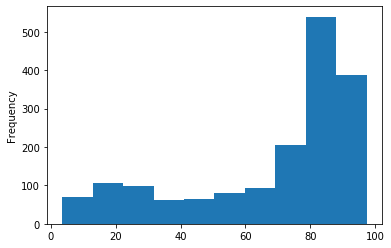

In [10]:
#using four-year cohort for the analysis
df_grad[df_grad['Cohort']=='Four Year']['GraduationRate'].plot(kind='hist')

In [11]:
#### check consistencies of StudentGroupType/StudentGroup names among all data frames --> change to match (except Military/Migrant/Foster which don't have in all three dfs)

# change  StudentGroup types to match
df_attendance.StudentGroupType.replace(['AllStudents', 'EnglishLearner', 'FederalRaceEthnicity', 'Income', 'Section504'],\
                                       ['All', 'ELL', 'Race', 'Low Income', 'Section 504'], inplace=True)

df_attendance['StudentGroupType'].sort_values().unique()


array(['All', 'ELL', 'Gender', 'Homeless', 'Low Income', 'Migrant',
       'MilitaryFamily', 'Race', 'SWD', 'Section 504'], dtype=object)

In [12]:
## change  StudentGroup types to match
df_grad.StudentGroupType.replace(['504', 'LowIncome', 'sped'], ['Section 504', 'Low Income', 'SWD'], inplace=True)

df_grad['StudentGroupType'].sort_values().unique()

array(['All', 'ELL', 'Foster', 'Gender', 'Homeless', 'Low Income',
       'Migrant', 'Race', 'SWD', 'Section 504'], dtype=object)

In [13]:
# change  StudentGroup types to match
df_assessment.StudentGroupType.replace(['English Language Learners', 'Students with Disabilities'], ['ELL', 'SWD'], inplace=True)

df_assessment['StudentGroupType'].sort_values().unique()

array(['All', 'ELL', 'Foster', 'Gender', 'Homeless', 'Low Income',
       'Migrant', 'Military', 'Race', 'SWD', 'Section 504'], dtype=object)

In [14]:
######################### read in and preprocess demographic makeup data ####################
df_enrolment = pd.read_csv('data/seattle_enrolment.csv')

#remove single entry column
df_enrolment = df_enrolment.drop(['County','ESDName','ESDOrganizationID','DistrictCode','DistrictName',\
                                  'DistrictOrganizationId','SchoolName','DataAsOf'],axis=1)

#rename columns
df_enrolment.columns = ['SchoolYear','OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid',\
                       'CurrentSchoolType', 'GradeLevel','All Students', 'Female', 'Male', 'Gender X',
       'American Indian/ Alaskan Native', 'Asian', 'Black/ African American','Hispanic/ Latino of any race(s)',
        'Native Hawaiian/ Other Pacific Islander', 'Two or More Races', 'White','English Language Learners', 
        'Foster Care', 'Homeless', 'Low-Income','Migrant', 'Military Parent', 'Mobile', 'Section 504',
       'Students with Disabilities', 'Non-English Language Learners', 'Non-Foster Care', 'Non-Homeless', 
        'Non-Low Income', 'Non Migrant','Non Military Parent', 'Non Mobile', 'Non Section 504',
       'Students without Disabilities']

In [15]:
#clean up demographic enrolment data
demographicList = ['Female', 'Male', 'Gender X',
    'American Indian/ Alaskan Native', 'Asian', 'Black/ African American',
    'Hispanic/ Latino of any race(s)','Native Hawaiian/ Other Pacific Islander', 
    'Two or More Races', 'White','English Language Learners', 'Foster Care', 'Homeless', 
    'Low-Income', 'Migrant', 'Military Parent','Mobile','Section 504','Students with Disabilities', 
    'Non-English Language Learners','Non-Foster Care','Non-Homeless','Non-Low Income', 
    'Non Migrant','Non Military Parent','Non Mobile','Non Section 504','Students without Disabilities']

#replace with null and compute percentage
for demo in demographicList:
    df_enrolment[demo] = df_enrolment[demo].fillna(0)
    df_enrolment[demo] = 100* df_enrolment[demo]/df_enrolment['All Students'] 

df_enrolment['All Students'] = 100.0

#replace for consistencies
df_enrolment.GradeLevel.replace(['AllGrades'], ['All Grades'], inplace=True)


In [16]:
################# demographic for 2018-19 (year of interest) ##################################
#get demographic (pivot from enrolment) to be joined with different measure dfs 
df_enrolment_2018 = df_enrolment[(df_enrolment['SchoolYear']=='2018-19') & (df_enrolment['OrganizationLevel']=='School')]

wantedGroup = ['Female', 'Male', 'Gender X','American Indian/ Alaskan Native','Asian','Black/ African American',
               'Hispanic/ Latino of any race(s)','Native Hawaiian/ Other Pacific Islander','Two or More Races','White',
               'English Language Learners','Foster Care','Homeless','Low-Income','Migrant','Military Parent','Mobile',
               'Section 504','Students with Disabilities','Non-English Language Learners','Non-Foster Care','Non-Homeless',
               'Non-Low Income','Non Migrant','Non Military Parent','Non Mobile','Non Section 504','Students without Disabilities']

#reformat enrolment
df_enrolment_2018 = df_enrolment_2018.set_index(['SchoolOrganizationid','GradeLevel'])
df_enrolment_2018.head()

SchoolYear OrganizationLevel  SchoolCode  \
SchoolOrganizationid GradeLevel                                            
101054.0             1st Grade     2018-19            School      2138.0   
                     2nd Grade     2018-19            School      2138.0   
                     3rd Grade     2018-19            School      2138.0   
                     4th Grade     2018-19            School      2138.0   
                     5th Grade     2018-19            School      2138.0   

                                CurrentSchoolType  All Students     Female  \
SchoolOrganizationid GradeLevel                                              
101054.0             1st Grade                  P         100.0  51.282051   
                     2nd Grade                  P         100.0  46.666667   
                     3rd Grade                  P         100.0  50.000000   
                     4th Grade                  P         100.0  52.808989   
                     5th Grade                  P         100.0  49.494949   

                                      Male  Gender X  \
SchoolOrganizationid GradeLevel                        
101054.0             1st Grade   48.717949       0.0   
                     2nd Grade   53.333333       0.0   
                     3rd Grade   50.000000       0.0   
                     4th Grade   47.191011       0.0   
                     5th Grade   50.505051       0.0   

                                 American Indian/ Alaskan Native     Asian  \
SchoolOrganizationid GradeLevel                                              
101054.0             1st Grade                          0.000000  1.282051   
                     2nd Grade                          0.000000  1.111111   
                     3rd Grade                          1.041667  2.083333   
                     4th Grade                          1.123596  0.000000   
                     5th Grade                          0.000000  2.020202   

                                 ...  Students with Disabilities  \
SchoolOrganizationid GradeLevel  ...                               
101054.0             1st Grade   ...                    6.410256   
                     2nd Grade   ...                    8.888889   
                     3rd Grade   ...                   20.833333   
                     4th Grade   ...                   21.348315   
                     5th Grade   ...                   16.161616   

                                 Non-English Language Learners  \
SchoolOrganizationid GradeLevel                                  
101054.0             1st Grade                       91.025641   
                     2nd Grade                       95.555556   
                     3rd Grade                       95.833333   
                     4th Grade                       96.629213   
                     5th Grade                       90.909091   

                                 Non-Foster Care  Non-Homeless  \
SchoolOrganizationid GradeLevel                                  
101054.0             1st Grade        100.000000     98.717949   
                     2nd Grade         98.888889    100.000000   
                     3rd Grade         98.958333     95.833333   
                     4th Grade        100.000000     96.629213   
                     5th Grade        100.000000     95.959596   

                                 Non-Low Income  Non Migrant  \
SchoolOrganizationid GradeLevel                                
101054.0             1st Grade        96.153846   100.000000   
                     2nd Grade        92.222222   100.000000   
                     3rd Grade        77.083333    98.958333   
                     4th Grade        80.898876   100.000000   
                     5th Grade        83.838384   100.000000   

                                 Non Military Parent  Non Mobile  \
SchoolOrganizationid GradeLevel                                    
101054.0             1st

In [17]:
#print to demographic file
fout = open ('demopct_2018.csv','w')
fout.write("SchoolOrganizationid,StudentGroup,GradeLevel,demoProportion\n")

for schoolId,grade in df_enrolment_2018.index:
    for group in wantedGroup:
       # print (df_enrolment_2018.loc[schoolId,group][grade])
        val = df_enrolment_2018.loc[schoolId,group][grade]
        if (np.isnan(val)):
            val = 0
        
        fout.write("%f,%s,%s,%f\n" %(schoolId, group, grade, val))

fout.close()

In [18]:
# read in demographic percentage (pct)
df_demopct_2018 = pd.read_csv('demopct_2018.csv')
df_demopct_2018.columns

Index(['SchoolOrganizationid', 'StudentGroup', 'GradeLevel', 'demoProportion'], dtype='object')

In [19]:
############ compute gaps among [ELL, Income, Race, Gender, Disabilities, 504, Homeless, Foster] groups ######################
          ## look at 1) Attendance (all students, 2018) 
                  #  2) Graduation (2018)
                  #  3) Acad. Perf. (WCAS-Sci & SBA Math-ELA; All students; 2018)
##############################################################################################################################


In [20]:
#### get data frame for #1-#3 

## 1) Attendance (all students, 2018) 
df_attendance_all_2018 = df_attendance[(df_attendance['SchoolYear']=='2018-19') & (df_attendance['OrganizationLevel']=='School') &\
                                       (df_attendance['GradeLevel']=='All Grades')].copy()

df_attendance_all_2018 = pd.merge(df_attendance_all_2018, df_demopct_2018, how='left',\
                                  on=['SchoolOrganizationid','StudentGroup','GradeLevel'])

df_attendance_all_2018['demoProportion'].fillna(0, inplace=True)

##  2) Graduation (2018)
df_grad_2018 = df_grad[(df_grad['SchoolYear']=='2018-19') & (df_grad['OrganizationLevel']=='School') &\
                            (df_grad['Cohort']=='Four Year')].copy()

df_grad_2018 = pd.merge(df_grad_2018, df_demopct_2018, how='left',\
                                  on=['SchoolOrganizationid','StudentGroup'])

df_grad_2018['demoProportion'].fillna(0, inplace=True)



In [21]:
##  3) Acad. Perf. (WCAS-Sci & SBA Math-ELA; 5th,8th,10th(11th); 2018)

df_WCASSci_All_2018 = df_assessment[(df_assessment['GradeLevel'] == 'All Grades') & (df_assessment['SchoolYear'] == '2018-19') & \
                              (df_assessment['TestAdministration'] == 'WCAS') & (df_assessment['TestSubject'] == 'Science')]

df_WCASSci_All_2018 = pd.merge(df_WCASSci_All_2018, df_demopct_2018, how='left',\
                                  on=['SchoolOrganizationid','StudentGroup','GradeLevel'])

df_WCASSci_All_2018['demoProportion'].fillna(0, inplace=True)

    #All math
df_SBACMath_All_2018 = df_assessment[(df_assessment['GradeLevel'] == 'All Grades') & (df_assessment['SchoolYear'] == '2018-19') & \
                              (df_assessment['TestAdministration'] == 'SBAC') & (df_assessment['TestSubject'] == 'Math')]

df_SBACMath_All_2018 = pd.merge(df_SBACMath_All_2018, df_demopct_2018, how='left',\
                                  on=['SchoolOrganizationid','StudentGroup','GradeLevel'])

df_SBACMath_All_2018['demoProportion'].fillna(0, inplace=True)

    #All ELA
df_SBACELA_All_2018 = df_assessment[(df_assessment['GradeLevel'] == 'All Grades') & (df_assessment['SchoolYear'] == '2018-19') & \
              (df_assessment['TestAdministration'] == 'SBAC') & (df_assessment['TestSubject'] == 'English Language Arts')]

df_SBACELA_All_2018 = pd.merge(df_SBACELA_All_2018, df_demopct_2018, how='left',\
                                  on=['SchoolOrganizationid','StudentGroup','GradeLevel']).fillna(0)

df_SBACELA_All_2018['demoProportion'].fillna(0, inplace=True)



In [22]:
# define function to calculate gap

# need clamp function for logit
def clamp(number, minVal, maxVal):
   return max(min(number, maxVal), minVal)

def calculateGap_logit (l): 
    #--input is list of tuples (count, measureValue)
    
    #if empty list or just one element, return 0 as gap
    if (len(l) < 1):
        return 0
    
    #first, calculate expected value
    expVal = 0
    ttol=0 
     
    for tl in l:
        ttol += tl[0]
        expVal += (tl[0] * tl[1])
    
    if(ttol == 0): return None
    expVal /= ttol
    
    #--this is new for Logit  vs original version: converting exp and obs values (logit) and take the difference (sq. diff)
    expVal_logit = clamp(expVal/100, 0.0001, 0.9999) #we were using percentage, not proportion so divide by 100
    expVal_logit = np.log(expVal_logit) - np.log(1 - expVal_logit)
    
    #compute gap (sum of square difference)
    gap=0
    for tl in l:
        obs_logit = clamp(tl[1]/100, 0.0001, 0.9999)
        obs_logit = np.log(obs_logit) - np.log(1 - obs_logit)
        gap += abs(obs_logit - expVal)
        
    return gap
   

In [24]:
#calculating gap in 2 measures, each and in 3 aspects
selectedCategory = {'ELL', 'Gender', 'Homeless', 'Low Income', 'Race', 'SWD', 'Section 504'}
selectedMeasure = { 'AllAttend': df_attendance_all_2018, 'grad': df_grad_2018,\
                    'AllSci' : df_WCASSci_All_2018, 'AllMath' : df_SBACMath_All_2018, 'AllELA' : df_SBACELA_All_2018}
columnName = {'AllAttend': 'Attendance', 'grad': 'GraduationRate',\
              'AllSci' : 'PercentMetStandard', 'AllMath' : 'PercentMetStandard', 'AllELA' : 'PercentMetStandard'}

gapResults_logit= {}

print ("calculating gap for....")

for measure in selectedMeasure.keys() : #[df_3rdELA, df_4thMath, df_Attend]:

    df_tmp = selectedMeasure[measure]

    for category in selectedCategory: 
        indexName = measure + "_" + category
        print (indexName)
        gapResults_logit[indexName] = {}

        for schoolId in df_tmp['SchoolOrganizationid'].unique():
            tmp = []
        
            for i,j in df_tmp.iterrows():
                if ( ( j['SchoolOrganizationid'] == schoolId ) & ( j['StudentGroupType'] == category ) & \
                     ( str(j[columnName[measure]]) != 'nan') ):
                    tmp.append( [j['demoProportion'], j[columnName[measure]]] )
   
            gapResults_logit[indexName][schoolId] = (calculateGap_logit(tmp))
            if (gapResults_logit[indexName][schoolId] == 0):
                gapResults_logit[indexName][schoolId] = 'NULL'
            

calculating gap for....
AllAttend_Section 504
AllAttend_Gender
AllAttend_Homeless
AllAttend_ELL
AllAttend_Race
AllAttend_Low Income
AllAttend_SWD
grad_Section 504
grad_Gender
grad_Homeless
grad_ELL
grad_Race
grad_Low Income
grad_SWD
AllSci_Section 504
AllSci_Gender
AllSci_Homeless
AllSci_ELL
AllSci_Race
AllSci_Low Income
AllSci_SWD
AllMath_Section 504
AllMath_Gender
AllMath_Homeless
AllMath_ELL
AllMath_Race
AllMath_Low Income
AllMath_SWD
AllELA_Section 504
AllELA_Gender
AllELA_Homeless
AllELA_ELL
AllELA_Race
AllELA_Low Income
AllELA_SWD


In [26]:
#format gap results and write to file
df_gapLogit = pd.DataFrame(gapResults_logit)
df_gapLogit = df_gapLogit.reset_index()

df_gapLogit.columns = ['SchoolOrganizationid', 'AllAttend_SWD', 'AllAttend_Gender', 'AllAttend_Race',
       'AllAttend_Homeless', 'AllAttend_ELL', 'AllAttend_Low Income',
       'AllAttend_Section 504', 'grad_SWD', 'grad_Gender', 'grad_Race',
       'grad_Homeless', 'grad_ELL', 'grad_Low Income', 'grad_Section 504',
       'AllSci_SWD', 'AllSci_Gender', 'AllSci_Race', 'AllSci_Homeless',
       'AllSci_ELL', 'AllSci_Low Income', 'AllSci_Section 504', 'AllMath_SWD',
       'AllMath_Gender', 'AllMath_Race', 'AllMath_Homeless', 'AllMath_ELL',
       'AllMath_Low Income', 'AllMath_Section 504', 'AllELA_SWD',
       'AllELA_Gender', 'AllELA_Race', 'AllELA_Homeless', 'AllELA_ELL',
       'AllELA_Low Income', 'AllELA_Section 504']

df_gapLogit.to_csv('gapresult-logit.csv',index=False)